In [ ]:
#Shuvani Choudhury(12768553)
#Purpose of code: To fit static GLS model and analyze economic policies' effects on AEX returns

In [10]:
#Import relevant packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.graphics.tsaplots as tsaplots
from statsmodels.compat import lzip
from scipy import stats
from statsmodels.stats.diagnostic import het_white
from statsmodels.stats.diagnostic import het_breuschpagan
from statistics import stdev
import statsmodels.tsa.stattools as ts
from scipy.interpolate import NearestNDInterpolator
from scipy.interpolate import LinearNDInterpolator
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [11]:
#Read excel file and calculate the log-returns
df = pd.read_excel('Netherlands Data.xlsx', index_col=0)
df['Stock_Price'] = 100*(np.log(df.Stock_Price) - np.log(df.Stock_Price.shift(1)))
print(df)

            Stock_Price  M1_Supply  Current_Account_Balance  \
Date                                                          
2015-01-01          NaN     444.09                      NaN   
2015-02-01     7.025398     442.81                      NaN   
2015-03-01     5.532203     445.29                 28525.34   
2015-04-01     1.982818     443.58                      NaN   
2015-05-01    -1.557727     446.16                      NaN   
2015-06-01    -2.269018     431.91                -14133.58   
2015-07-01     0.828649     435.24                      NaN   
2015-08-01    -3.388374     433.63                      NaN   
2015-09-01    -9.050203     416.69                 16730.84   
2015-10-01     3.972002     423.68                      NaN   
2015-11-01     4.212428     435.29                      NaN   
2015-12-01    -5.366054     428.28                 17347.75   
2016-01-01    -5.756598     434.13                      NaN   
2016-02-01    -1.568136     444.42                     

       Stock_Price   M1_Supply  Current_Account_Balance  Unemployment_Rate  \
count    65.000000   65.000000                21.000000          66.000000   
mean      0.391110  434.208308             19660.004286           0.048561   
std       4.589055   20.570966              8772.046451           0.013750   
min     -24.871372  394.680000            -14133.580000           0.029000   
25%      -0.762521  419.130000             17347.750000           0.036000   
50%       0.756711  437.210000             21984.050000           0.046000   
75%       3.137858  447.030000             24095.510000           0.062500   
max       7.300441  496.510000             28525.340000           0.072000   

       Bond_Yield  Price_Deflator      FOREX       Real_GDP     Corona  
count   66.000000       21.000000  66.000000      21.000000  66.000000  
mean     0.315515       99.685433  35.459091  174118.242857   0.106061  
std      0.376491        2.650755   3.069242    6974.252381   0.310275  
min  

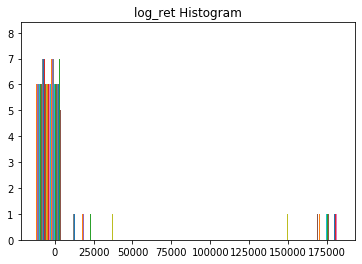

In [12]:
#Describe dataset using descriptive statistics
print(df.describe())
print(df.kurtosis());
print(df.skew());
plt.hist(df);
plt.title('log_ret Histogram');

In [13]:
#Split dataset into those regressors that need, and that don't need interpolation
df2=df.dropna()
coords = np.array(df2.iloc[2:-1,[0,1,3,4,6]])

#All regressors that need interpolation
pred_1 = np.array(df2.iloc[2:-1,2])
pred_2 = np.array(df2.iloc[2:-1,5])
pred_3 = np.array(df2.iloc[2:-1,7])

#Define individual linear interpolations
interp1 = LinearNDInterpolator(coords, pred_1)
interp2 = LinearNDInterpolator(coords, pred_2)
interp3 = LinearNDInterpolator(coords, pred_3)

#Use linear interpolation
result1 = interp1(np.array(df.iloc[2:-1,0]),np.array(df.iloc[2:-1,1]),np.array(df.iloc[2:-1,3]),np.array(df.iloc[2:-1,4]),np.array(df.iloc[2:-1,6]))
result2 = interp2(np.array(df.iloc[2:-1,0]),np.array(df.iloc[2:-1,1]),np.array(df.iloc[2:-1,3]),np.array(df.iloc[2:-1,4]),np.array(df.iloc[2:-1,6]))
result3 = interp3(np.array(df.iloc[2:-1,0]),np.array(df.iloc[2:-1,1]),np.array(df.iloc[2:-1,3]),np.array(df.iloc[2:-1,4]),np.array(df.iloc[2:-1,6]))

#Combine results into dataframe
result=np.vstack((result1,result2,result3)).T
result=pd.DataFrame(result, index=df.iloc[2:-1,[0,1,3,4,6]].index)
result.columns =['Current_Account_Balance',  'Price_Deflator',  'Real_GDP']
print(result)

            Current_Account_Balance  Price_Deflator       Real_GDP
Date                                                              
2015-03-01                      NaN             NaN            NaN
2015-04-01                      NaN             NaN            NaN
2015-05-01                      NaN             NaN            NaN
2015-06-01                      NaN             NaN            NaN
2015-07-01                      NaN             NaN            NaN
2015-08-01                      NaN             NaN            NaN
2015-09-01             16730.840000       95.660254  163163.800000
2015-10-01                      NaN             NaN            NaN
2015-11-01                      NaN             NaN            NaN
2015-12-01             17347.750000       98.320606  170865.600000
2016-01-01                      NaN             NaN            NaN
2016-02-01                      NaN             NaN            NaN
2016-03-01             13244.580000       99.540017  164549.40

In [14]:
#Combine original dataset with new interpolated regressors
interp_df = df.iloc[2:-1,[2,5,7]]
interp_df = interp_df.combine_first(result)
df3 = df.iloc[2:-1,:]
df3.iloc[:,2]=interp_df.iloc[:,0]
df3.iloc[:,5]=interp_df.iloc[:,1]
df3.iloc[:,7]=interp_df.iloc[:,2]
print(df3)

            Stock_Price  M1_Supply  Current_Account_Balance  \
Date                                                          
2015-03-01     5.532203     445.29             28525.340000   
2015-04-01     1.982818     443.58                      NaN   
2015-05-01    -1.557727     446.16                      NaN   
2015-06-01    -2.269018     431.91            -14133.580000   
2015-07-01     0.828649     435.24                      NaN   
2015-08-01    -3.388374     433.63                      NaN   
2015-09-01    -9.050203     416.69             16730.840000   
2015-10-01     3.972002     423.68                      NaN   
2015-11-01     4.212428     435.29                      NaN   
2015-12-01    -5.366054     428.28             17347.750000   
2016-01-01    -5.756598     434.13                      NaN   
2016-02-01    -1.568136     444.42                      NaN   
2016-03-01     6.918804     447.02             13244.580000   
2016-04-01     0.944338     447.03                     

In [15]:
#Split dataset into regressors that don't and that do need interpolation
df2=df3.dropna()
coords = np.array(df2.iloc[:,[0,1,3,4,6]])
pred_1 = np.array(df2.iloc[:,2])
pred_2 = np.array(df2.iloc[:,5])
pred_3 = np.array(df2.iloc[:,7])

#Define Nearest Neighobor interpolators
interp1 = NearestNDInterpolator(coords, pred_1)
interp2 = NearestNDInterpolator(coords, pred_2)
interp3 = NearestNDInterpolator(coords, pred_3)

#Run nearest neighbor interpolation
result1 = interp1(np.array(df3.iloc[:,0]),np.array(df3.iloc[:,1]),np.array(df3.iloc[:,3]),np.array(df3.iloc[:,4]),np.array(df3.iloc[:,6]))
result2 = interp2(np.array(df3.iloc[:,0]),np.array(df3.iloc[:,1]),np.array(df3.iloc[:,3]),np.array(df3.iloc[:,4]),np.array(df3.iloc[:,6]))
result3 = interp3(np.array(df3.iloc[:,0]),np.array(df3.iloc[:,1]),np.array(df3.iloc[:,3]),np.array(df3.iloc[:,4]),np.array(df3.iloc[:,6]))

#Combine regressors into dataframe
result=np.vstack((result1,result2,result3)).T
result=pd.DataFrame(result, index=df3.iloc[:,[0,1,3,4,6]].index)
result.columns =['Current_Account_Balance',  'Price_Deflator',  'Real_GDP']
print(result)

            Current_Account_Balance  Price_Deflator       Real_GDP
Date                                                              
2015-03-01             28525.340000      102.005582  161105.200000
2015-04-01             23202.640000      105.155615  185335.800000
2015-05-01             18616.674676       98.884737  174113.211932
2015-06-01            -14133.580000       98.032649  168328.200000
2015-07-01             14078.040000       96.482490  166632.000000
2015-08-01            -14133.580000       98.032649  168328.200000
2015-09-01             16730.840000       95.660254  163163.800000
2015-10-01             20634.030000       97.602454  185460.500000
2015-11-01             14078.040000       96.482490  166632.000000
2015-12-01             17347.750000       98.320606  170865.600000
2016-01-01            -14133.580000       98.032649  168328.200000
2016-02-01             23202.640000      105.155615  185335.800000
2016-03-01             13244.580000       99.540017  164549.40

In [16]:
#Combine original dataset with interpolated regressors
interp_df = df3.iloc[:,[2,5,7]]
interp_df = interp_df.combine_first(result)
df3 = df.iloc[2:-1,:]
df3.iloc[:,2]=interp_df.iloc[:,0]
df3.iloc[:,5]=interp_df.iloc[:,1]
df3.iloc[:,7]=interp_df.iloc[:,2]
print(df3)

            Stock_Price  M1_Supply  Current_Account_Balance  \
Date                                                          
2015-03-01     5.532203     445.29             28525.340000   
2015-04-01     1.982818     443.58             23202.640000   
2015-05-01    -1.557727     446.16             18616.674676   
2015-06-01    -2.269018     431.91            -14133.580000   
2015-07-01     0.828649     435.24             14078.040000   
2015-08-01    -3.388374     433.63            -14133.580000   
2015-09-01    -9.050203     416.69             16730.840000   
2015-10-01     3.972002     423.68             20634.030000   
2015-11-01     4.212428     435.29             14078.040000   
2015-12-01    -5.366054     428.28             17347.750000   
2016-01-01    -5.756598     434.13            -14133.580000   
2016-02-01    -1.568136     444.42             23202.640000   
2016-03-01     6.918804     447.02             13244.580000   
2016-04-01     0.944338     447.03             18616.67

       Stock_Price   M1_Supply  Current_Account_Balance  Unemployment_Rate  \
count    63.000000   63.000000                63.000000          63.000000   
mean      0.176132  433.914921             19874.253105           0.047921   
std       4.495766   20.831690              8564.002477           0.013428   
min     -24.871372  394.680000            -14133.580000           0.029000   
25%      -1.149975  418.510000             18616.674676           0.035500   
50%       0.748257  435.840000             22458.520000           0.045000   
75%       2.629005  447.675000             24095.510000           0.060500   
max       6.918804  496.510000             28525.340000           0.070000   

       Bond_Yield  Price_Deflator      FOREX       Real_GDP     Corona  
count   63.000000       63.000000  63.000000      63.000000  63.000000  
mean     0.323302       99.752228  35.253968  174811.156825   0.095238  
std      0.377169        2.535911   2.926758    6218.905123   0.295901  
min  

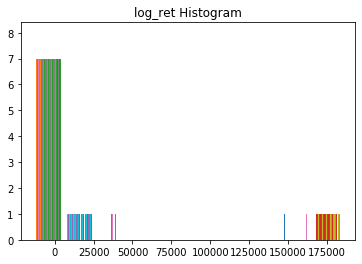

In [17]:
#Print descriptive statistics for new, interpolated dataset
print(df3.describe())
print(df3.kurtosis());
print(df3.skew());
plt.hist(df3);
plt.title('log_ret Histogram');

In [18]:
#Create additional possible regressors
df3['Cond_M1lag1']=df3.M1_Supply.shift(1)*df3.Corona.shift(1)
df3['Cond_CABlag1']=df3.Current_Account_Balance.shift(1)*df3.Corona.shift(1)
df3['Cond*BY']=df3.Bond_Yield*df3.Corona
df3['CAB_lag1']=df3.Current_Account_Balance.shift(1)
df3['CAB_lag2']=df3.Current_Account_Balance.shift(2)
df3['CAB_lag3']=df3.Current_Account_Balance.shift(3)
df3['CAB_lag4']=df3.Current_Account_Balance.shift(4)
df3['for_lag1']=df3.FOREX.shift(1)
df3['for_lag2']=df3.FOREX.shift(2)
df3['BY_lag2']=df3.Bond_Yield.shift(2)
df3['Cond_BYl1']=df3.Bond_Yield.shift(1)*df3.Corona
df3['Cond_BYl2']=df3.Cond_BYl1.shift(1)
df3['Cond_BYl3']=df3.Cond_BYl1.shift(2)
df3['Cond_BYl4']=df3.Cond_BYl1.shift(3)
df3['Cond_BYl5']=df3.Cond_BYl1.shift(4)
df3['M1_lag1']=df3.M1_Supply.shift(1)
df3['M1_lag2']=df3.M1_Supply.shift(2)
df3['M1_lag3']=df3.M1_Supply.shift(3)
df3['UR_lag1']=df3.Unemployment_Rate.shift(1)
df3['UR_lag2']=df3.Unemployment_Rate.shift(2)
df3['UR_lag3']=df3.Unemployment_Rate.shift(3)
df3['PD_lag1']=df3.Price_Deflator.shift(1)
df3['PD_lag2']=df3.Price_Deflator.shift(2)
df3['PD_lag3']=df3.Price_Deflator.shift(3)
df3['R_GDP_lag1']=df3.Real_GDP.shift(1)
df3['R_GDP_lag2']=df3.Real_GDP.shift(2)
df3['R_GDP_lag3']=df3.Real_GDP.shift(3)
print(df3)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

            Stock_Price  M1_Supply  Current_Account_Balance  \
Date                                                          
2015-03-01     5.532203     445.29             28525.340000   
2015-04-01     1.982818     443.58             23202.640000   
2015-05-01    -1.557727     446.16             18616.674676   
2015-06-01    -2.269018     431.91            -14133.580000   
2015-07-01     0.828649     435.24             14078.040000   
2015-08-01    -3.388374     433.63            -14133.580000   
2015-09-01    -9.050203     416.69             16730.840000   
2015-10-01     3.972002     423.68             20634.030000   
2015-11-01     4.212428     435.29             14078.040000   
2015-12-01    -5.366054     428.28             17347.750000   
2016-01-01    -5.756598     434.13            -14133.580000   
2016-02-01    -1.568136     444.42             23202.640000   
2016-03-01     6.918804     447.02             13244.580000   
2016-04-01     0.944338     447.03             18616.67

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexi

In [19]:
#Choose OLS model for studying corona's significance based on AIC, BIC, and adjusted R-squared values
y=np.array(df3.iloc[5:,0])
x=np.array(df3.iloc[5:,[1,2,3,4,5,6,7,8,12,17,18,24,26,28,30,32,34]])
x = sm.add_constant(x)
model = sm.OLS(y, x)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.444
Model:                            OLS   Adj. R-squared:                  0.208
Method:                 Least Squares   F-statistic:                     1.883
Date:                Mon, 10 Aug 2020   Prob (F-statistic):             0.0504
Time:                        19:03:18   Log-Likelihood:                -153.39
No. Observations:                  58   AIC:                             342.8
Df Residuals:                      40   BIC:                             379.9
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         39.4557     73.875      0.534      0.5

In [20]:
#Run breuschpagan test
het_test = het_breuschpagan(results.resid, x)
print(het_test)

(26.53853523733248, 0.06519201535560398, 1.984764943214959, 0.037713341963677594)


In [21]:
#Use available code to organize vif values for regressors in model and reduce regressors
#source: https://www.analyticsvidhya.com/blog/2020/03/what-is-multicollinearity/
def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

print(calc_vif(df3.iloc[5:,[1,2,3,4,5,6,7,8,12,17,18,24,26,28,30,32,34]]))
print(calc_vif(df3.iloc[5:,[1,2,4,7,8,12,18,28,34]]))

                  variables          VIF
0                 M1_Supply  2117.991337
1   Current_Account_Balance    17.482797
2         Unemployment_Rate  1481.307728
3                Bond_Yield    14.374755
4            Price_Deflator  3545.079501
5                     FOREX  2313.035752
6                  Real_GDP  1311.488089
7                    Corona     3.972702
8                  CAB_lag1    16.823970
9                  for_lag2  3016.344043
10                  BY_lag2    18.532966
11                  M1_lag1  2536.064138
12                  M1_lag3  1383.104664
13                  UR_lag2  1282.513268
14                  PD_lag1  3215.120139
15                  PD_lag3  2512.253013
16               R_GDP_lag2  1068.819448
                 variables         VIF
0                M1_Supply  589.244552
1  Current_Account_Balance   12.467499
2               Bond_Yield    7.187204
3                 Real_GDP  652.004218
4                   Corona    1.990898
5                 CAB_lag1  

In [22]:
#Run OLS model on less multicollinear regressors
y=np.array(df3.iloc[5:,0])
x=np.array(df3.iloc[5:,[1,2,4,7,8,12,18,28,34]])
x = sm.add_constant(x)
model = sm.OLS(y, x)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.228
Model:                            OLS   Adj. R-squared:                  0.083
Method:                 Least Squares   F-statistic:                     1.575
Date:                Mon, 10 Aug 2020   Prob (F-statistic):              0.150
Time:                        19:03:25   Log-Likelihood:                -162.93
No. Observations:                  58   AIC:                             345.9
Df Residuals:                      48   BIC:                             366.5
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.0958     36.683      0.193      0.8

In [23]:
#Run breuschpagan test on new model results
het_test = het_breuschpagan(results.resid, x)
print(het_test)

(17.692413786278834, 0.03891449921198177, 2.340987120716399, 0.028057754669502236)


In [24]:
#Run GLS model due to existant heteroskedasticity
glsar_model = sm.GLSAR(y, x)
glsar_results = glsar_model.iterative_fit(1)
print(glsar_results.summary())

                           GLSAR Regression Results                           
Dep. Variable:                      y   R-squared:                       0.233
Model:                          GLSAR   Adj. R-squared:                  0.087
Method:                 Least Squares   F-statistic:                     1.590
Date:                Mon, 10 Aug 2020   Prob (F-statistic):              0.146
Time:                        19:03:27   Log-Likelihood:                -160.12
No. Observations:                  57   AIC:                             340.2
Df Residuals:                      47   BIC:                             360.7
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.9010     36.750      0.188      0.8

In [25]:
#Choose and run OLS model to study individual policy effects during pandemic (choose based on AIC, BIC, and adjusted R-squared)
y=np.array(df3.iloc[5:,0])
x=np.array(df3.iloc[5:,[1,2,3,4,5,6,7,9,10,12,13,14,15,16,17,18,19,20,21,22,23]])
x = sm.add_constant(x)
model = sm.OLS(y, x)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.813
Model:                            OLS   Adj. R-squared:                  0.713
Method:                 Least Squares   F-statistic:                     8.068
Date:                Mon, 10 Aug 2020   Prob (F-statistic):           3.21e-08
Time:                        19:03:27   Log-Likelihood:                -121.74
No. Observations:                  58   AIC:                             285.5
Df Residuals:                      37   BIC:                             328.8
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -107.6044     33.917     -3.173      0.0

In [26]:
#Run breuschpagan test on results
het_test = het_breuschpagan(results.resid, x)
print(het_test)

(9.135634860975363, 0.988106132193584, 0.34587422643718774, 0.9931104255006126)


In [27]:
#Calculate vif values for all regressors in model and reduce multicollinearity
print(calc_vif(df3.iloc[5:,[1,2,3,4,5,6,7,9,10,12,13,14,15,16,17,18,19,20,21,22,23]]))
print(calc_vif(df3.iloc[5:,[1,2,3,4,7,9,10,12,13,14,15,18,19]]))

                  variables          VIF
0                 M1_Supply   940.975933
1   Current_Account_Balance    27.742149
2         Unemployment_Rate   121.220670
3                Bond_Yield    17.058560
4            Price_Deflator  2281.970775
5                     FOREX  3711.091581
6                  Real_GDP  1538.051458
7               Cond_M1lag1          inf
8              Cond_CABlag1          inf
9                  CAB_lag1    15.200482
10                 CAB_lag2    13.560436
11                 CAB_lag3    15.496374
12                 CAB_lag4    13.268647
13                 for_lag1  5254.530711
14                 for_lag2  4563.740312
15                  BY_lag2    19.989232
16                Cond_BYl1    14.161410
17                Cond_BYl2          inf
18                Cond_BYl3          inf
19                Cond_BYl4          inf
20                Cond_BYl5          inf
                  variables         VIF
0                 M1_Supply  613.654310
1   Current_Accoun

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:185: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


In [28]:
#Run OLS on less multicollinear set of regressors
y=np.array(df3.iloc[5:,0])
x=np.array(df3.iloc[5:,[1,2,3,4,7,9,10,12,13,14,15,18,19]])
x = sm.add_constant(x)
model = sm.OLS(y, x)
results = model.fit()
ols_resid=results.resid
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.509
Model:                            OLS   Adj. R-squared:                  0.364
Method:                 Least Squares   F-statistic:                     3.507
Date:                Mon, 10 Aug 2020   Prob (F-statistic):           0.000886
Time:                        19:03:29   Log-Likelihood:                -149.81
No. Observations:                  58   AIC:                             327.6
Df Residuals:                      44   BIC:                             356.5
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -47.0060     24.886     -1.889      0.0

In [29]:
#Run Breuschpagan test on model results
het_test = het_breuschpagan(results.resid, x)
print(het_test)

(41.38775774818052, 8.241960102829527e-05, 8.432434314752646, 3.462636534184225e-08)


In [30]:
#Run GLS model due to existant heteroskedasticity
glsar_model = sm.GLSAR(y, x)
glsar_results = glsar_model.iterative_fit(1)
print(glsar_results.summary())

                           GLSAR Regression Results                           
Dep. Variable:                      y   R-squared:                       0.506
Model:                          GLSAR   Adj. R-squared:                  0.356
Method:                 Least Squares   F-statistic:                     3.383
Date:                Mon, 10 Aug 2020   Prob (F-statistic):            0.00127
Time:                        19:03:31   Log-Likelihood:                -147.62
No. Observations:                  57   AIC:                             323.2
Df Residuals:                      43   BIC:                             351.8
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -47.6093     25.172     -1.891      0.0